Device: mps
features: 6 classes: 7
MLP(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=256, out_features=7, bias=True)
  )
)


/opt/anaconda3/envs/genomics/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01 — train_loss: 0.7097 — val_macro_f1: 0.4084 — time: 40.9s
Epoch 02 — train_loss: 0.5843 — val_macro_f1: 0.4135 — time: 38.6s
Epoch 03 — train_loss: 0.5381 — val_macro_f1: 0.4136 — time: 37.5s
Epoch 04 — train_loss: 0.5100 — val_macro_f1: 0.4122 — time: 36.1s
Epoch 05 — train_loss: 0.4919 — val_macro_f1: 0.4257 — time: 36.3s
Epoch 06 — train_loss: 0.4786 — val_macro_f1: 0.4173 — time: 37.4s
Epoch 07 — train_loss: 0.4696 — val_macro_f1: 0.4200 — time: 37.1s
Epoch 08 — train_loss: 0.4636 — val_macro_f1: 0.4161 — time: 36.8s
Epoch 09 — train_loss: 0.4573 — val_macro_f1: 0.4027 — time: 37.3s
Epoch 10 — train_loss: 0.4455 — val_macro_f1: 0.4273 — time: 37.0s
Epoch 11 — train_loss: 0.4429 — val_macro_f1: 0.4138 — time: 39.2s
Epoch 12 — train_loss: 0.4411 — val_macro_f1: 0.4163 — time: 42.1s
Epoch 13 — train_loss: 0.4391 — val_macro_f1: 0.4286 — time: 42.1s
Epoch 14 — train_loss: 0.4368 — val_macro_f1: 0.4137 — time: 36.9s
Epoch 15 — train_loss: 0.4362 — val_macro_f1: 0.4164 — time: 3

/var/folders/jx/cc9brgl143z9wt4bc65wylz40000gn/T/ipykernel_93967/575979112.py:205: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_mlp.p

Test classification report:
              precision    recall  f1-score   support

           0     0.4686    0.7694    0.5825    253225
           1     0.8243    0.4298    0.5650    387994
           2     0.6395    0.6640    0.6515     92775
           3     0.0067    0.6311    0.0133       103
           4     0.1861    0.9624    0.3118       372
           5     0.0082    0.7065    0.0162        92
           6     0.7354    0.9904    0.8440      1877

    accuracy                         0.5778    736438
   macro avg     0.4098    0.7362    0.4263    736438
weighted avg     0.6779    0.5778    0.5824    736438



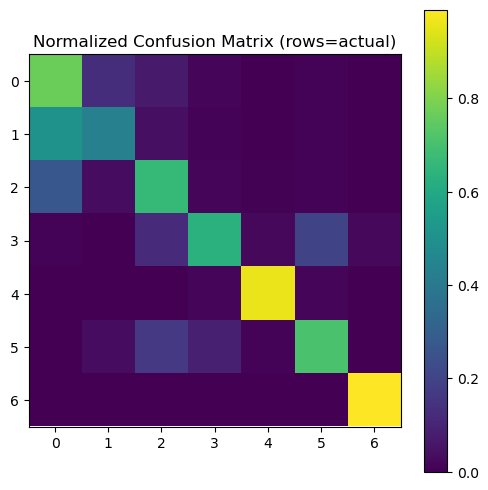

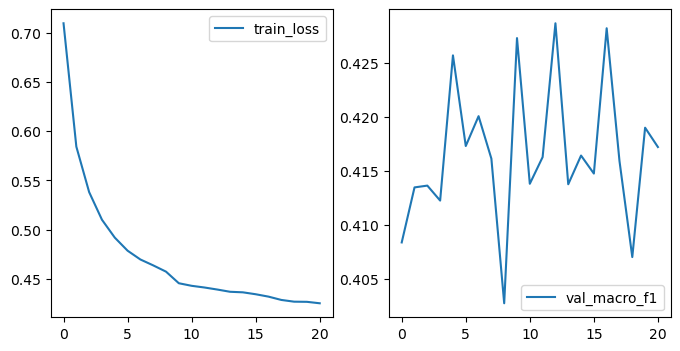

In [1]:
# Neural network (PyTorch) pipeline for tabular classification on M1 (MPS) or CPU
# Requirements: torch, scikit-learn, pandas, numpy, matplotlib
# Install (if needed): conda-forge pytorch or pip install torch -- note: prefer conda-forge for MPS support

import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
import time

# ---------- 0. Device ----------
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

# ---------- 1. Inputs: adapt if X are DataFrames or numpy ----------
# Expect: X_train, X_test, y_train, y_test exist in the environment.
# If not, you can create a validation split from your train as below:
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

df = pd.read_csv('data/ml_ready_genomics.csv', index_col=False)
X = df.drop('Clinical_Significance_Encoded', axis=1)
y = df['Clinical_Significance_Encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to pandas if numpy
def to_pandas(X):
    if isinstance(X, np.ndarray):
        return pd.DataFrame(X)
    return X.copy()

X_train_df = to_pandas(X_train)
X_test_df  = to_pandas(X_test)
y_train_arr = np.array(y_train)
y_test_arr  = np.array(y_test)

# Optional: create a small validation split from train
X_tr_df, X_val_df, y_tr_arr, y_val_arr = train_test_split(
    X_train_df, y_train_arr, stratify=y_train_arr, test_size=0.1, random_state=42
)

# ---------- 2. Preprocessing ----------
# If you have categorical columns (object / category dtype), one-hot them.
def preprocess_df(train_df, val_df, test_df):
    # detect categorical columns
    cat_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
    if len(cat_cols) > 0:
        # one-hot encode using pandas.get_dummies (fit on train and align)
        train_enc = pd.get_dummies(train_df, columns=cat_cols, drop_first=False)
        val_enc   = pd.get_dummies(val_df,   columns=cat_cols, drop_first=False)
        test_enc  = pd.get_dummies(test_df,  columns=cat_cols, drop_first=False)
        # align columns
        train_enc, val_enc = train_enc.align(val_enc, join='left', axis=1, fill_value=0)
        train_enc, test_enc = train_enc.align(test_enc, join='left', axis=1, fill_value=0)
        Xtr = train_enc
        Xval = val_enc
        Xt = test_enc
    else:
        Xtr, Xval, Xt = train_df.copy(), val_df.copy(), test_df.copy()

    # scale numeric features
    scaler = StandardScaler()
    Xtr_scaled = pd.DataFrame(scaler.fit_transform(Xtr), columns=Xtr.columns, index=Xtr.index)
    Xval_scaled = pd.DataFrame(scaler.transform(Xval), columns=Xval.columns, index=Xval.index)
    Xt_scaled = pd.DataFrame(scaler.transform(Xt), columns=Xt.columns, index=Xt.index)
    return Xtr_scaled, Xval_scaled, Xt_scaled, scaler

X_tr, X_val, X_t, scaler = preprocess_df(X_tr_df, X_val_df, X_test_df)

# Convert to numpy arrays for PyTorch
X_tr_np = X_tr.values.astype('float32')
X_val_np = X_val.values.astype('float32')
X_t_np = X_t.values.astype('float32')

num_features = X_tr_np.shape[1]
num_classes = len(np.unique(y_train_arr))
print("features:", num_features, "classes:", num_classes)

# ---------- 3. Dataset & DataLoader ----------
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(np.array(y)).long()
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TabularDataset(X_tr_np, y_tr_arr)
val_ds   = TabularDataset(X_val_np, y_val_arr)
test_ds  = TabularDataset(X_t_np, y_test_arr)

# Option A: Use WeightedRandomSampler to balance batches during training
# Compute weights per sample from class frequencies
class_sample_counts = np.bincount(y_tr_arr, minlength=num_classes)
class_weights = 1.0 / (class_sample_counts + 1e-12)
sample_weights = class_weights[y_tr_arr]
sample_weights = torch.from_numpy(sample_weights.astype('float32'))
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

batch_size = 1024  # reduce if memory issues
train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=0)

# ---------- 4. Model definition (MLP) ----------
class MLP(nn.Module):
    def __init__(self, in_dim, hidden=[512,256,128], num_classes=2, p=0.3):
        super().__init__()
        layers = []
        prev = in_dim
        for h in hidden:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p))
            prev = h
        layers.append(nn.Linear(prev, num_classes))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# sensible architecture
model = MLP(num_features, hidden=[1024, 512, 256], num_classes=num_classes, p=0.3).to(device)
print(model)

# ---------- 5. Loss, optimizer, scheduler ----------
# Option: use class weights in loss instead of sampler — pick one approach. We already used sampler.
# If using class weights, compute and send to CrossEntropyLoss:
# cls_weights = torch.tensor(class_weights_array, dtype=torch.float32).to(device)
# criterion = nn.CrossEntropyLoss(weight=cls_weights)

criterion = nn.CrossEntropyLoss()  # sampler handles balancing in minibatches
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

# ---------- 6. Training loop with early stopping ----------
def evaluate(model, loader):
    model.eval()
    ys_all = []
    preds_all = []
    probs_all = []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            logits = model(Xb)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            preds = probs.argmax(axis=1)
            ys_all.append(yb.numpy())
            preds_all.append(preds)
            probs_all.append(probs)
    y_true = np.concatenate(ys_all)
    y_pred = np.concatenate(preds_all)
    y_prob = np.vstack(probs_all)
    return y_true, y_pred, y_prob

best_val_macro_f1 = 0.0
epochs = 50
patience = 8
no_improve = 0
history = {"train_loss": [], "val_macro_f1": []}

from sklearn.metrics import f1_score

for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0.0
    t0 = time.time()
    for Xb, yb in train_loader:
        Xb = Xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    # Validation
    y_val_true, y_val_pred, _ = evaluate(model, val_loader)
    val_macro_f1 = f1_score(y_val_true, y_val_pred, average='macro')
    scheduler.step(val_macro_f1)
    history["train_loss"].append(train_loss)
    history["val_macro_f1"].append(val_macro_f1)
    elapsed = time.time() - t0
    print(f"Epoch {epoch:02d} — train_loss: {train_loss:.4f} — val_macro_f1: {val_macro_f1:.4f} — time: {elapsed:.1f}s")
    # early stopping
    if val_macro_f1 > best_val_macro_f1 + 1e-4:
        best_val_macro_f1 = val_macro_f1
        no_improve = 0
        torch.save(model.state_dict(), "best_mlp.pth")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping — no improvement")
            break

# load best model
model.load_state_dict(torch.load("best_mlp.pth"))

# ---------- 7. Evaluate on test set ----------
y_true, y_pred, y_prob = evaluate(model, test_loader)
print("Test classification report:")
print(classification_report(y_true, y_pred, digits=4))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm / cm.sum(axis=1, keepdims=True), interpolation='nearest')
plt.title("Normalized Confusion Matrix (rows=actual)")
plt.colorbar()
plt.show()

# ---------- 8. Plot training curves ----------
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="train_loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history["val_macro_f1"], label="val_macro_f1")
plt.legend()
plt.show()

# ---------- 9. Optional: save scaler and model ----------
# import joblib
# joblib.dump(scaler, "scaler.joblib")
# torch.save(model.state_dict(), "mlp_final.pth")
# print("Saved scaler and model.")
